# PyDMD

## Tutorial 6: Descomposición en modo dinámico de orden superior en instantáneas de baja dimensión

En este tutorial mostraremos la aplicación de la descomposición en modo dinámico de orden superior (para una descripción completa lea el trabajo original de [Soledad Le Clainche y José M. Vega](https://epubs.siam.org/doi/10.1137/15M1054924 )). Este método permite aplicar el DMD también cuando la dimensión de las instantáneas es menor que el número de instantáneas: a continuación consideraremos un caso límite, tratando con instantáneas 1D.

First of all we import the HODMD class from the pydmd package, we set matplotlib for the notebook and we import numpy.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from pydmd import HODMD
from pydmd.plotter import plot_eigs

Ahora, creamos nuestro conjunto de datos de juguete: evaluamos una función no lineal en puntos equiespaciados para simular una señal temporal. Aquí nuestra función:
$
f(t) = \cos(t)\sin(\cos(t)) + \cos(\frac{t}{5})
$

In [27]:
def myfunc(x):
    return np.cos(x) * np.sin(np.cos(x)) + np.cos(x * 0.2)

Como confiamos en la potencia del DMD, agregamos un poco de ruido y trazamos nuestra función:

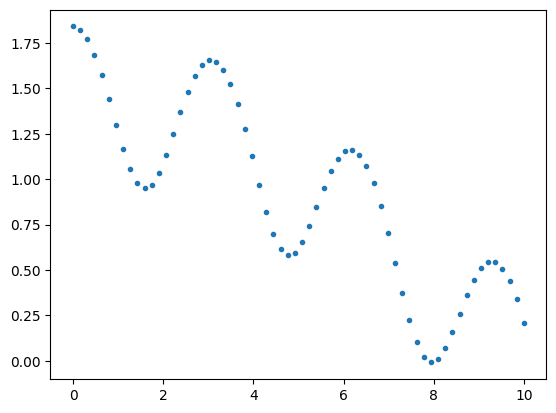

In [28]:
x = np.linspace(0, 10, 64)
y = myfunc(x)
snapshots = y
plt.plot(x, snapshots, ".")
plt.show()

Ahora creamos el objeto `HODMD`: además de los parámetros DMD habituales, tenemos el parámetro `d`. Básicamente, con este método se reorganiza la matriz de instantáneas inicial para poder extraer las estructuras principales mediante la descomposición en valores singulares. Este parámetro `d` maneja esta disposición (para más detalles, consulte la documentación [HODMD](https://mathlab.github.io/PyDMD/hodmd.html)).

In [29]:
hodmd = HODMD(svd_rank=0, exact=True, opt=True, d=30).fit(snapshots[None])

A pesar de la disposición, la forma de los datos reconstruidos es la misma que la entrada original.

In [30]:
hodmd.reconstructed_data.shape

(1, 64)

Como siempre, echamos un vistazo a los valores propios para comprobar la estabilidad del sistema.

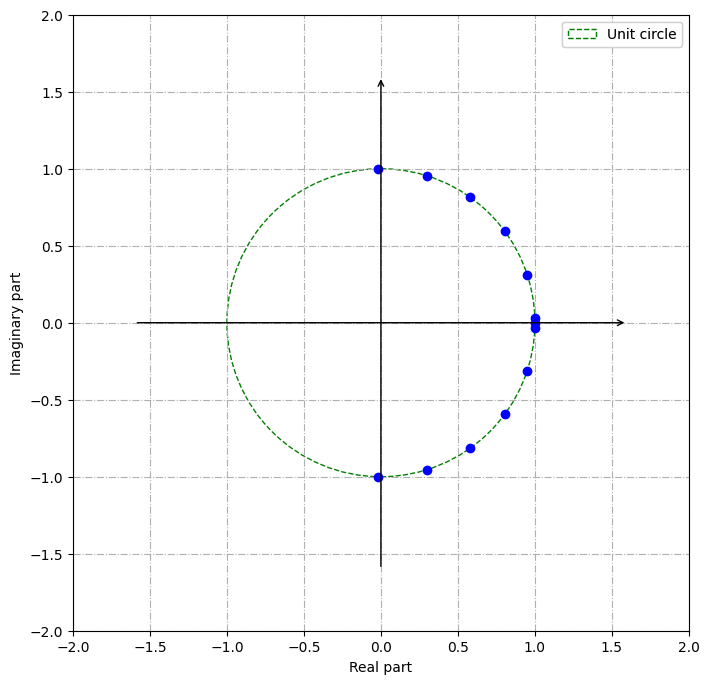

In [31]:
plot_eigs(hodmd)

Ahora podemos comparar la salida de DMD con el conjunto de datos inicial: trazamos las instantáneas, la función original que estamos intentando reconstruir y la reconstrucción de DMD.

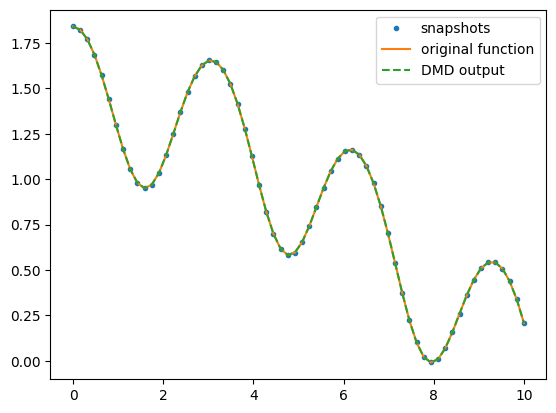

In [32]:
# Aqui se marcan los limites con el problema original 

# Intervalo de tiempo
hodmd.original_time["dt"] = hodmd.dmd_time["dt"] = x[1] - x[0]

# Primer instante de tiempo
hodmd.original_time["t0"] = hodmd.dmd_time["t0"] = x[0]

#Instante de tiempo Final
hodmd.original_time["tend"] = hodmd.dmd_time["tend"] = x[-1]

plt.plot(hodmd.original_timesteps, snapshots, ".", label="snapshots")

plt.plot(hodmd.original_timesteps, y, "-", label="original function")

plt.plot(hodmd.dmd_timesteps,hodmd.reconstructed_data[0].real,"--",label="DMD output")

plt.legend()

plt.show()

¡Bastante bien! A ver si podemos verlo en el futuro.

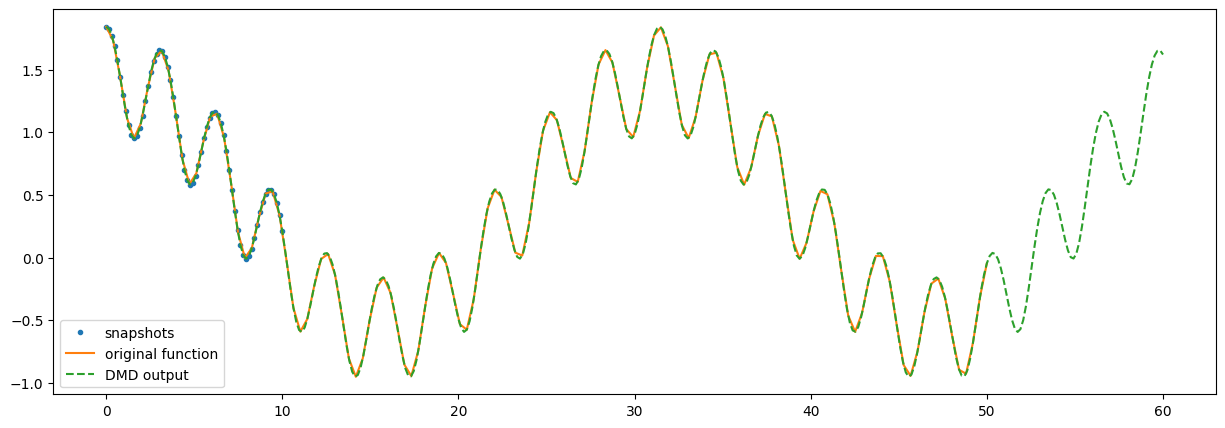

In [35]:
hodmd.dmd_time["tend"] = 60


fig = plt.figure(figsize=(15, 5))
plt.plot(hodmd.original_timesteps, snapshots, ".", label="snapshots")

plt.plot(
    np.linspace(0, 50, 128),
    myfunc(np.linspace(0, 50, 128)),
    "-",
    label="original function",
)

plt.plot(
    hodmd.dmd_timesteps,
    hodmd.reconstructed_data[0].real,
    "--",
    label="DMD output",
)

plt.legend()
plt.show()

La reconstrucción es perfecta. También cuando el tiempo está alejado de las instantáneas.

Podemos comprobar qué sucede si añadimos algo de ruido.

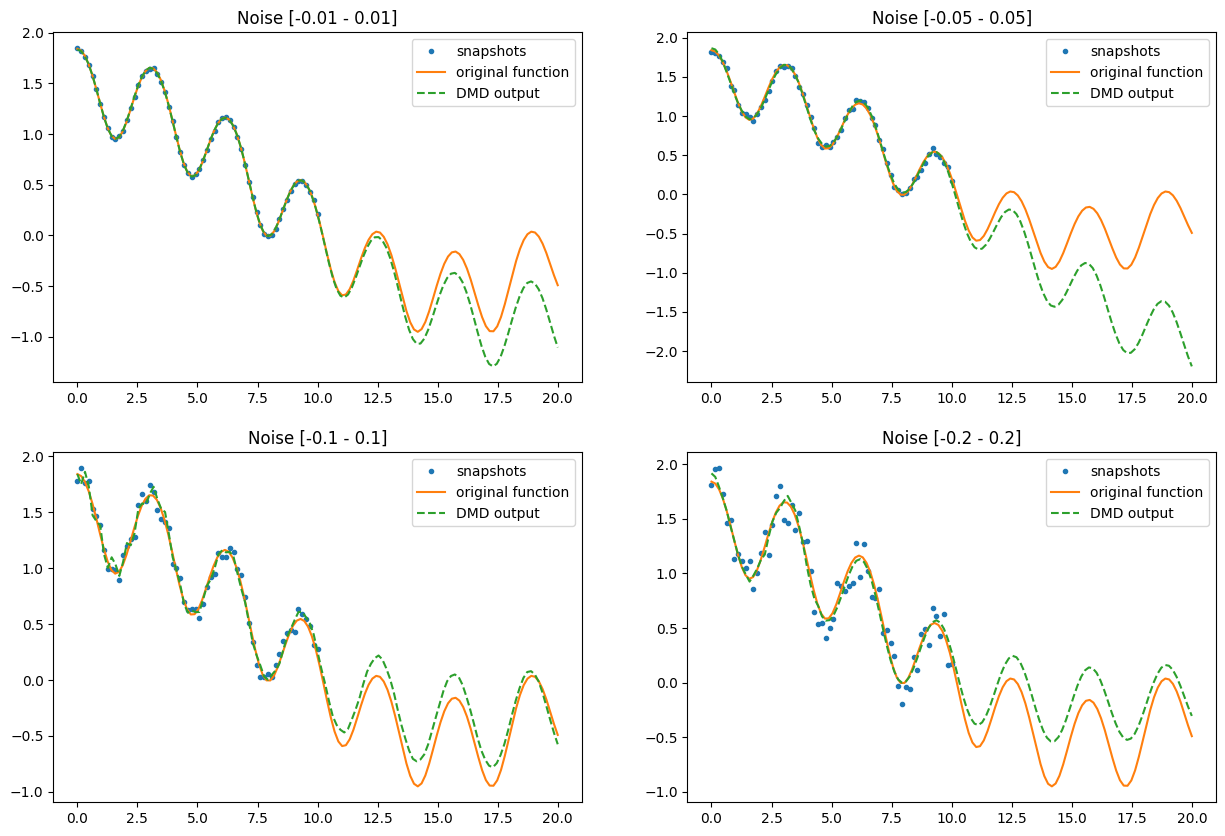

In [ ]:
noise_range = [0.01, 0.05, 0.1, 0.2]
fig = plt.figure(figsize=(15, 10))
future = 20

for id_plot, i in enumerate(noise_range, start=1):
    snapshots = y + np.random.uniform(-i, i, size=y.shape)
    hodmd = HODMD(svd_rank=0, exact=True, opt=True, d=30).fit(snapshots[None])
    hodmd.original_time["dt"] = hodmd.dmd_time["dt"] = x[1] - x[0]
    hodmd.original_time["t0"] = hodmd.dmd_time["t0"] = x[0]
    hodmd.original_time["tend"] = hodmd.dmd_time["tend"] = x[-1]
    hodmd.dmd_time["tend"] = 20

    plt.subplot(2, 2, id_plot)
    plt.plot(hodmd.original_timesteps, snapshots, ".", label="snapshots")
    plt.plot(
        np.linspace(0, future, 128),
        myfunc(np.linspace(0, future, 128)),
        "-",
        label="original function",
    )
    plt.plot(
        hodmd.dmd_timesteps,
        hodmd.reconstructed_data[0].real,
        "--",
        label="DMD output",
    )
    plt.legend()
    plt.title("Noise [{} - {}]".format(-i, i))
plt.show()

Los resultados son obviamente peores, pero dependiendo de la cantidad de ruido, la salida HODMD coincide bastante bien con la función original, al menos en una predicción a corto plazo. En cambio, dentro de la ventana temporal, puede reconstruir muy bien la tendencia y eliminar el ruido de los datos de entrada.